In [1]:
from datasketch import MinHash, MinHashLSH
from multiprocessing import Pool, cpu_count
import pandas as pd
from tqdm import tqdm
import re

tqdm.pandas()

In [2]:
cxr_reports = pd.read_csv("/scratch/baj321/cxr_reports.csv")
mimic_notes = pd.read_csv("/scratch/baj321/MIMIC-Note/physionet.org/files/mimic-iv-note/2.2/note/radiology.csv")

In [3]:
# Finding subject_ids in mimic_notes but not in cxr_reports
mimic_only_subject_ids = set(mimic_notes['subject_id'].unique()) - set(cxr_reports['subject_id'].unique())

# Finding subject_ids in cxr_reports but not in mimic_notes
cxr_only_subject_ids = set(cxr_reports['subject_id'].unique()) - set(mimic_notes['subject_id'].unique())

mimic_only_subject_ids = list(mimic_only_subject_ids)
cxr_only_subject_ids = list(cxr_only_subject_ids)

print("Number of subject_ids in mimic_notes but not in cxr_reports:", len(mimic_only_subject_ids))
print("Number of subject_ids in cxr_reports but not in mimic_notes:", len(cxr_only_subject_ids))


Number of subject_ids in mimic_notes but not in cxr_reports: 175710
Number of subject_ids in cxr_reports but not in mimic_notes: 3662


In [4]:
def preprocess(text):
    if pd.isnull(text):
        print('text is', text)
        return set()
    
    #Remove everything up to the literal string "FINAL REPORT\n"
    match = re.search(r"FINAL REPORT\n", text, re.IGNORECASE)
    if match:
        text = text[match.end():]  # Keep only text after "FINAL REPORT\n"
    text = re.sub(r"___M|___F|___|[.,!?/:;\\]", "", text)
    #Remove all formatting: no spaces, literal "\n" strings, or newlines
    text = re.sub(r"\s+|\\n", "", text)  # Remove spaces and literal "\n" strings
    return text
    
def preprocess_mimic_notes(text):
    if pd.isnull(text):
        print('text is', text)
        return set()
        
    text = re.sub(r"___M|___F|___|[.,!?/:;\\]", "", text)
    
    # Remove all formatting: no spaces, literal "\n" strings, or newlines
    text = re.sub(r"\s+|\\n", "", text)  # Remove spaces and literal "\n" strings
    return text

In [14]:
common_subject_mimic_notes = mimic_notes[~mimic_notes['subject_id'].isin(mimic_only_subject_ids)]
len(common_subject_mimic_notes)

1097916

In [15]:
common_subject_mimic_notes['processed_text'] = common_subject_mimic_notes['text'].progress_apply(preprocess_mimic_notes)

100%|██████████| 1097916/1097916 [02:12<00:00, 8304.42it/s]
/scratch/baj321/conda-envs/medfuse_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
common_subject_cxr_reports = cxr_reports[~cxr_reports['subject_id'].isin(cxr_only_subject_ids)]
len(common_subject_cxr_reports)

215822

In [17]:
common_subject_cxr_reports['processed_text'] = common_subject_cxr_reports['cxr_report_text'].progress_apply(preprocess)

100%|██████████| 215822/215822 [00:13<00:00, 15740.03it/s]
/scratch/baj321/conda-envs/medfuse_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
# Merge the two dataframes on 'subject_id'
merged_common_df = common_subject_mimic_notes.merge(
    common_subject_cxr_reports, on='subject_id', suffixes=('_mimic', '_cxr')
)

# Function to find and mark direct matches for each subject_id group
def mark_direct_matches(group):
    mimic_text_set = set(group['processed_text_mimic'].dropna().unique())
    cxr_text_set = set(group['processed_text_cxr'].dropna().unique())
    
    # Find matches
    mimic_matches = group['processed_text_mimic'].isin(cxr_text_set)
    cxr_matches = group['processed_text_cxr'].isin(mimic_text_set)
    
    # Add match columns
    group = group.assign(
        mimic_match=mimic_matches,
        cxr_match=cxr_matches
    )
    return group

# Group by 'subject_id' and apply `mark_direct_matches` in parallel
grouped = list(merged_common_df.groupby('subject_id'))
num_cores = min(cpu_count(), 28)

with Pool(num_cores) as pool:
    results = list(tqdm(pool.imap(mark_direct_matches, [group for _, group in grouped]),
                        total=len(grouped), desc="Marking Matches by Subject ID"))

# Concatenate the results into a single DataFrame
marked_df = pd.concat(results, ignore_index=True)

# Filter to get unique mimic_notes and cxr_reports
unique_mimic_notes = marked_df.loc[
    (~marked_df['mimic_match']) & marked_df['processed_text_mimic'].notnull()
].drop_duplicates(subset=['note_id', 'processed_text_mimic'])

unique_cxr_reports = marked_df.loc[
    (~marked_df['cxr_match']) & marked_df['processed_text_cxr'].notnull()
].drop_duplicates(subset=['study_id', 'processed_text_cxr'])

# Extract only the relevant columns
unique_mimic_notes = unique_mimic_notes[['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'text','processed_text_mimic' ]]
unique_cxr_reports = unique_cxr_reports[['subject_id','study_id','cxr_report_text','processed_text_cxr']]

# `unique_mimic_notes` and `unique_cxr_reports` now contain the lists of unique notes and reports based on direct equality


Marking Matches by Subject ID: 100%|██████████| 61717/61717 [00:46<00:00, 1336.02it/s]


In [19]:
#163486 mimic notes removed
#163473 cxr notes removed
print('Unique Mimic Notes:', len(unique_mimic_notes))
print('Unique CXR Reports:', len(unique_cxr_reports))

Unique Mimic Notes: 934430
Unique CXR Reports: 52349


In [20]:
# Merge the two dataframes on 'subject_id'
merged_common_df = common_subject_mimic_notes.merge(common_subject_cxr_reports, on='subject_id', suffixes=('_mimic', '_cxr'))

# Define a function to calculate Jaccard similarity between two sets of text
def jaccard_similarity(text1, text2):
    set1 = set(text1.split())
    set2 = set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Define a function to process each group and mark matches
def mark_similarities(group):
    mimic_entries = group['text'].unique()
    cxr_entries = group['cxr_report_text'].unique()

    # Initialize columns for marking matches
    group['mimic_match'] = False
    group['cxr_match'] = False
    group['jaccard_score'] = 0.0

    # Loop through each row in the group
    for idx, row in group.iterrows():
        mimic_text = row['text']
        cxr_text = row['cxr_report_text']

        jaccard_score = jaccard_similarity(mimic_text, cxr_text)
        group.at[idx, 'jaccard_score'] = jaccard_score

        # Check for similarity
        mimic_similar = any(jaccard_similarity(mimic_text, cxr) > 0.5 for cxr in cxr_entries)
        cxr_similar = any(jaccard_similarity(cxr_text, mimic) > 0.5 for mimic in mimic_entries)

        # Mark if a match is found
        if mimic_similar:
            group.at[idx, 'mimic_match'] = True
        if cxr_similar:
            group.at[idx, 'cxr_match'] = True

    return group

# Split the DataFrame by subject_id
grouped = list(merged_common_df.groupby('subject_id'))

# Use the number of available CPUs or a set number if desired
num_cores = min(cpu_count(), 28)

with Pool(num_cores) as pool:
    # Process each group in parallel and combine the results
    results = list(tqdm(pool.imap(mark_similarities, [group for _, group in grouped]), total=len(grouped), desc="Marking Matches by Subject ID"))

# Concatenate results into a single DataFrame
marked_df = pd.concat(results, ignore_index=True)

# Filter to get unique mimic_notes and cxr_reports
unique_mimic_notes = marked_df[(~marked_df['mimic_match']) & marked_df['text'].notnull()].drop_duplicates(subset=['note_id', 'text'])
unique_cxr_reports = marked_df[(~marked_df['cxr_match']) & marked_df['cxr_report_text'].notnull()].drop_duplicates(subset=['study_id', 'cxr_report_text'])

# Optionally, extract only the relevant columns
unique_mimic_notes = unique_mimic_notes[['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text','processed_text_mimic' ]]
unique_cxr_reports = unique_cxr_reports[['subject_id','study_id','cxr_report_text','processed_text_cxr']]
# Now, `unique_mimic_notes` and `unique_cxr_reports` contain the lists of unique notes and reports


Marking Matches by Subject ID: 100%|██████████| 61717/61717 [20:33<00:00, 50.05it/s] 


In [11]:
pip install matplotlib

  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.7 MB/s eta 0:00:00
  Using cached Pillow-9.5.0-cp37-cp37m-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
marked_df = pd.read_csv("/scratch/baj321/marked_df.csv")

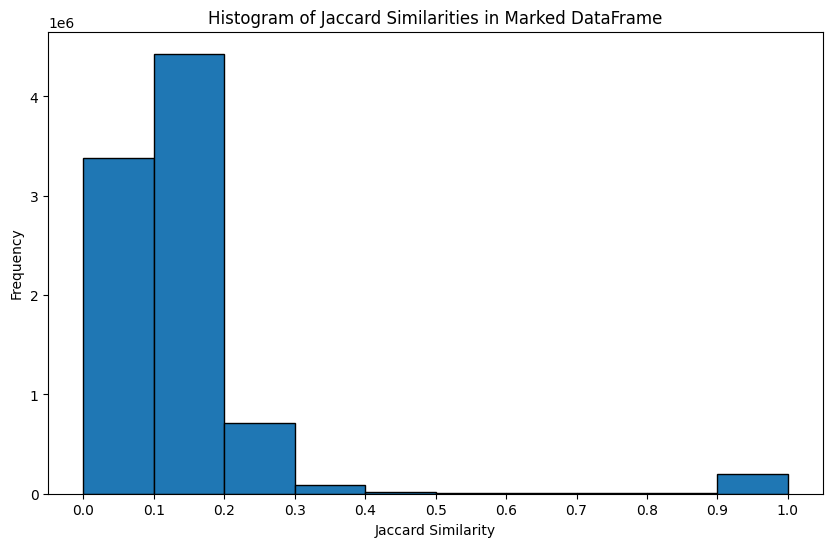

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define bin edges for intervals of 0.1 between 0 and 1
bins = np.arange(0, 1.1, 0.1)  # Includes 1.0 as the end point

# Plotting the histogram of Jaccard similarities in 'marked_df'
plt.figure(figsize=(10, 6))
plt.hist(marked_df['jaccard_score'], bins=bins, edgecolor='black')
plt.title('Histogram of Jaccard Similarities in Marked DataFrame')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Frequency')
plt.xticks(bins)  # Ensures x-ticks align with bin edges
plt.show()


In [11]:
# Basic statistics: min, max, mean, median, standard deviation, and quartiles for 'jaccard_score'
stats = {
    'Min': marked_df['jaccard_score'].min(),
    'Max': marked_df['jaccard_score'].max(),
    'Mean': marked_df['jaccard_score'].mean(),
    'Median': marked_df['jaccard_score'].median(),
    'Standard Deviation': marked_df['jaccard_score'].std(),
    '25th Percentile (Q1)': marked_df['jaccard_score'].quantile(0.25),
    '50th Percentile (Q2/Median)': marked_df['jaccard_score'].quantile(0.5),
    '75th Percentile (Q3)': marked_df['jaccard_score'].quantile(0.75),
    '90th Percentile': marked_df['jaccard_score'].quantile(0.9),
    '95th Percentile': marked_df['jaccard_score'].quantile(0.95)
}

# Display basic statistics
print("Basic Statistics for jaccard_score")
for stat, value in stats.items():
    print(f"{stat}: {value}")


Basic Statistics for jaccard_score
Min: 0.0
Max: 0.990909090909091
Mean: 0.14300364961442077
Median: 0.1130434782608695
Standard Deviation: 0.13805064619906116
25th Percentile (Q1): 0.0851063829787234
50th Percentile (Q2/Median): 0.1130434782608695
75th Percentile (Q3): 0.1532846715328467
90th Percentile: 0.209090909090909
95th Percentile: 0.2625


In [13]:
# Filter for values between 0.8 and 0.9
filtered_value_counts = value_counts[(value_counts.index > 0.7) & (value_counts.index < 0.9)]

print("\nValue Counts for jaccard_score between 0.8 and 0.9:")
print(filtered_value_counts)


NameError: name 'value_counts' is not defined

In [20]:
file_path = '/scratch/baj321/marked_df.csv'
marked_df.to_csv(file_path, index=False)

In [40]:
# Sort the DataFrame by 'jaccard_score' in ascending order
sorted_df = marked_df.sort_values(by='jaccard_score')

# Filter rows with 'jaccard_score' between 0.8 and 0.9
filtered_df = sorted_df[
    (sorted_df['jaccard_score'] > 0.4) &
    (sorted_df['jaccard_score'] < 0.9) &
    (sorted_df['cxr_match'] == False) &
    (sorted_df['mimic_match'] == False)
]

In [47]:
# Print the first matching row's details
num=0
print("Jaccard:",filtered_df.iloc[num].jaccard_score)
print("Mimic Note:", filtered_df.iloc[num].text)
print("CXR REPORT:", filtered_df.iloc[num].cxr_report_text)
print(len(filtered_df))

Jaccard: 0.4014084507042254
Mimic Note: PA AND LATERAL VIEWS OF THE CHEST

REASON FOR EXAM:  Asthma and cough.  Patient is status post radical
prostatectomy.

Comparison is made with CT ___.

Cardiac size is normal. There is increase in the mediastinal fat at the left
cardiophrenic angle. There is blunting of the left costophrenic angle and
elevation of the left hemidiaphragm, likely chronic.  The lungs are grossly
clear.  The lungs are hyperinflated consistent with emphysema.  

IMPRESSION:
No evidence of pneumonia.

CXR REPORT:  WET READ: ___ ___ 9:06 PM
  Opacity with angular margins at the left lung base anteriorly with elevated
  left hemidiaphragm. Prior imaging studies are not available for viewing, but
  reports from prior chest radiographs and CTs in the Atrius system describe
  known chronic left pleural scarring from prior surgery. Given the angular
  margins of this density and volume loss in this area, this most likely
  corresponds to known chronic scarring. But in the ab

In [37]:
filtered_df.head()

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text,processed_text_mimic,study_id,cxr_report_text,processed_text_cxr,mimic_match,cxr_match,jaccard_score
7599018,18581793-AR-24,18581793,29083316.0,AR,24,2146-08-24 13:08:00,2146-08-24 16:39:00,ADDENDUM My initial review of more than a doz...,ADDENDUMMyinitialreviewofmorethanadozenofthisp...,51808073,FINAL ADDENDU...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONyearoldm...,False,False,0.502439
421453,10541652-RR-102,10541652,26489597.0,RR,102,2168-08-29 22:27:00,2168-08-30 10:45:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONyoMwcomp...,57922580,FINAL REPORT\...,EXAMINATIONCHEST(PAANDLAT)INDICATIONyoMwcomple...,True,True,0.502825
5901309,16669225-RR-54,16669225,20887418.0,RR,54,2155-07-21 07:46:00,2155-07-21 15:12:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONCADMRhtn...,53267724,FINAL REPORT\...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONCADMRhtn...,True,True,0.502890
5901245,16669225-RR-47,16669225,20887418.0,RR,47,2155-07-15 08:23:00,2155-07-15 10:34:00,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONCADMRhtn...,54087614,FINAL REPORT\...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONCADMRhtn...,True,True,0.502890
8595431,19705230-RR-11,19705230,29218436.0,RR,11,2135-05-30 20:48:00,2135-05-31 10:41:00,EXAMINATION: CHEST PORT. LINE PLACEMENT\n\nIN...,EXAMINATIONCHESTPORTLINEPLACEMENTINDICATIONyea...,59860087,FINAL REPORT\...,EXAMINATIONCHEST(PORTABLEAP)INDICATIONyearoldm...,False,True,0.503106


In [21]:
# Filter to get unique mimic_notes and cxr_reports
unique_mimic_notes = marked_df[(~marked_df['mimic_match']) & marked_df['text'].notnull()].drop_duplicates(subset=['subject_id','note_id', 'text'])
unique_cxr_reports = marked_df[(~marked_df['cxr_match']) & marked_df['cxr_report_text'].notnull()].drop_duplicates(subset=['subject_id','study_id', 'cxr_report_text'])

# Optionally, extract only the relevant columns
unique_mimic_notes = unique_mimic_notes[['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'text','processed_text_mimic' ]]
unique_cxr_reports = unique_cxr_reports[['subject_id','study_id','cxr_report_text','processed_text_cxr']]
# Now, `unique_mimic_notes` and `unique_cxr_reports` contain the lists of unique notes and reports

#no subject id
#194984 mimic notes removed
#194970 cxr reports removed

#with subject id
#194984 mimic notes removed
#194970 cxr reports removed
print('Unique Mimic Notes:', len(unique_mimic_notes))
print('Unique CXR Reports:', len(unique_cxr_reports))

Unique Mimic Notes: 884897
Unique CXR Reports: 3493


In [22]:
#0.9 threshold
# we have 20852 cxr reports in mimic-cxr that belong to patients represented in mimic-note but that are not included in the mimic-note radiology dataset
# we have 12013 cxr reports in mimic-cxr that belong to patients not represented in mimic-note

# USABLE: we have 902932 reports in mimic-note that belong to patients who are represented in mimic-cxr but that are not copies of the reports there
# we have 1223439 reports in mimic-note that belong to patients not represented in mimic-cxr

In [21]:
# Write the DataFrame to a CSV file
cxr_file_path = '/scratch/baj321/unique_cxr_reports.csv'
unique_cxr_reports.to_csv(cxr_file_path, index=False)
file_path = '/scratch/baj321/unique_mimic_notes.csv'
unique_mimic_notes.to_csv(file_path, index=False)

In [ ]:
#0.3 threshold
# we have 3493 cxr reports in mimic-cxr that belong to patients represented in mimic-note but that are not included in the mimic-note radiology dataset
# we have 12013 cxr reports in mimic-cxr that belong to patients not represented in mimic-note

# USABLE: we have 884897 reports in mimic-note that belong to patients who are represented in mimic-cxr but that are not copies of the reports there
# we have 1223439 reports in mimic-note that belong to patients not represented in mimic-cxr

In [22]:
filtered_df = unique_mimic_notes[unique_mimic_notes['text'].str.contains(r'\b(chest|radiograph|AP|lateral)\b', case=False, na=False)]
print(len(filtered_df))
print(filtered_df.head())

/scratch/baj321/conda-envs/medfuse_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


445854
            note_id  subject_id  hadm_id note_type  note_seq  \
127  10000935-RR-45    10000935      NaN        RR        45   
133  10000935-RR-46    10000935      NaN        RR        46   
139  10000935-RR-47    10000935      NaN        RR        47   
181  10000935-RR-58    10000935      NaN        RR        58   
193  10000935-RR-60    10000935      NaN        RR        60   

               charttime            storetime  \
127  2182-10-06 11:24:00  2182-10-06 15:20:00   
133  2182-11-28 10:45:00  2182-11-28 17:23:00   
139  2182-11-28 10:45:00  2182-11-28 17:22:00   
181  2184-11-25 09:27:00  2184-11-25 13:46:00   
193  2185-12-24 19:33:00  2185-12-24 20:51:00   

                                                  text  \
127  PA AND LATERAL CHEST, ___\n\nHISTORY:  Status ...   
133  HISTORY:  ___ female with osteoarthritis of bi...   
139  HISTORY:  ___ female with history of herniated...   
181  INDICATION:  Right knee osteoarthritis.\n\nCOM...   
193  RIGHT ANKLE AND FO

In [24]:
num = 0
print(filtered_df['subject_id'].iloc[num])
print(filtered_df['text'].iloc[num])

10000935
PA AND LATERAL CHEST, ___

HISTORY:  Status post right lower lobe resection for carcinoid.  Now short of
breath.

IMPRESSION:  PA and lateral chest compared to ___:

There has been no interval radiographic change.  Lung volumes are small and
the right hemidiaphragm is moderately elevated.  Pleural thickening joins the
left lower costal pleural margin, unchanged.  No focal pulmonary abnormality
is seen.  There is no left pleural effusion.  The right hemidiaphragm remains
elevated.  Heart size normal.  Upper mediastinum has normal contours. 
Granulomatous calcifications are seen in hilar nodes.

Periosteal regrowth does not fully bridge surgical fracture of the right
posterior sixth rib.



In [44]:
# all 6 available cxr's for patient 10000935 do not match the cxr report in mimic-note
print(cxr_reports[cxr_reports['subject_id']==10000935].iloc[5].cxr_report_text)

                                 FINAL REPORT
 CHEST RADIOGRAPHS
 
 HISTORY:  Metastatic disease with known pulmonary metastases, presenting with
 fever and leukocytosis.
 
 COMPARISONS:  Radiographs from ___ as well as CT of the abdomen
 and pelvis from that same day.  Radiographs are also available from ___.
 
 FINDINGS:  The lung volumes are low.  The cardiac, mediastinal and hilar
 contours appear unchanged, allowing for differences in technique.  There are a
 number of round nodular densities projecting over each upper lung, but more
 numerous and discretely visualized in the left upper lobe, similar to prior
 study.  However, in addition, there is a more hazy widespread opacity
 projecting over the left mid upper lung which could be compatible with a
 coinciding pneumonia.  Pulmonary nodules in the left upper lobe are also not
 completely characterized on this study.  There is no pleural effusion or
 pneumothorax.  Post-operative changes are similar along the right chest wall.
 


In [60]:
# Step 1: Count entries in `marked_df` where `mimic_match` is True and `text` is null
null_text_count = marked_df[(marked_df['mimic_match']) & marked_df['text'].isnull()].shape[0]
print(f"Number of entries where `mimic_match` is True and `text` is null: {null_text_count}")

# Step 2: Identify subjects with multiple matches
# Filter rows with `mimic_match` as True
matched_mimic_notes = marked_df[marked_df['mimic_match']]

# Group by `subject_id` to count the number of matches per subject
subject_match_counts = matched_mimic_notes.groupby('subject_id').size().reset_index(name='match_count')

# Filter for subjects with more than one match
subjects_with_multiple_matches = subject_match_counts[subject_match_counts['match_count'] > 1]

# Display details for subjects with multiple matches to inspect
# Filter original dataframe to get all rows for these subjects
detailed_subject_matches = matched_mimic_notes[matched_mimic_notes['subject_id'].isin(subjects_with_multiple_matches['subject_id'])]

# Display details of these multiple matches
detailed_subject_matches = detailed_subject_matches[['subject_id', 'note_id', 'text', 'cxr_report_text', 'mimic_match', 'cxr_match', 'processed_text_cxr', 'processed_text_mimic']]

processed_mimic_groups = detailed_subject_matches.groupby('processed_text_mimic').filter(lambda x: x['note_id'].nunique() > 1)

# Display the filtered DataFrame
print(len(processed_mimic_groups))
print(processed_mimic_groups.head())

Number of entries where `mimic_match` is True and `text` is null: 0
2765
       subject_id         note_id  \
28143    10027100  10027100-RR-17   
28144    10027100  10027100-RR-17   
28145    10027100  10027100-RR-17   
28146    10027100  10027100-RR-17   
28147    10027100  10027100-RR-17   

                                                    text  \
28143  INDICATION:  Chest pain.\n\nCOMPARISON:  Chest...   
28144  INDICATION:  Chest pain.\n\nCOMPARISON:  Chest...   
28145  INDICATION:  Chest pain.\n\nCOMPARISON:  Chest...   
28146  INDICATION:  Chest pain.\n\nCOMPARISON:  Chest...   
28147  INDICATION:  Chest pain.\n\nCOMPARISON:  Chest...   

                                         cxr_report_text  mimic_match  \
28143                                   FINAL REPORT\...         True   
28144                                   FINAL REPORT\...         True   
28145                                   FINAL REPORT\...         True   
28146                                   FINAL REPOR

In [72]:
# Filter entries where 'processed_text_mimic' and 'subject_id' match, but 'note_id' is different
processed_mimic_groups = detailed_subject_matches.groupby(['processed_text_mimic', 'subject_id']).filter(lambda x: x['note_id'].nunique() > 1).drop_duplicates(subset=['note_id'])

# Display the filtered DataFrame
print(len(processed_mimic_groups))

71


In [78]:
processed_mimic_groups['subject_id'].nunique()

32

In [67]:
processed_mimic_groups = processed_mimic_groups[processed_mimic_groups['subject_id']==19891680]

In [68]:
print(len(processed_mimic_groups))
print(processed_mimic_groups['note_id'].nunique())
print(processed_mimic_groups.head(7))

2
2
         subject_id        note_id  \
8759840    19891680  19891680-RR-2   
8759841    19891680  19891680-RR-3   

                                                      text  \
8759840  INDICATION:  ___ man with vagus nerve stimulat...   
8759841  INDICATION:  ___ man with vagus nerve stimulat...   

                                           cxr_report_text  mimic_match  \
8759840                                   FINAL REPORT\...         True   
8759841                                   FINAL REPORT\...         True   

         cxr_match                                 processed_text_cxr  \
8759840       True  INDICATION-year-oldmanwithvagusnervestimulator...   
8759841       True  INDICATION-year-oldmanwithvagusnervestimulator...   

                                      processed_text_mimic  
8759840  INDICATIONmanwithvagusnervestimulatorwhichhasb...  
8759841  INDICATIONmanwithvagusnervestimulatorwhichhasb...  


In [69]:
print(processed_mimic_groups.text.iloc[0])
print(processed_mimic_groups.text.iloc[1])

INDICATION:  ___ man with vagus nerve stimulator which has been
disconnected, but the ED lead remains in place.  Evaluate lead to determine
whether it is safe to have spine MRI.

TECHNIQUE:  Chest PA and lateral.  Soft tissue neck AP and lateral.

COMPARISON:  None available.

FINDINGS: 

A disconnected left vagus nerve stimulator lead is in place.

Chest: Cardiac, mediastinal, and hilar contours are within normal limits. 
There is no evidence for pulmonary consolidation, pulmonary edema, pleural
effusion, or pneumothorax.  There are endplate degenerative changes in the
thoracic spine and a mild dextroconvex curvature in the upper thoracic spine.

Neck:  The contours of the aerodigestive tract are unremarkable.  There are
multilevel degenerative changes in the cervical spine, including minimal
retrolisthesis at C3-C4 and C4-C5, and bilateral uncovertebral spurring from
C4-C5 through C6-C7.

IMPRESSION:


1. A disconnected left vagus nerve stimulator lead is in place.
2. Degenerative ch

In [46]:
detailed_subject_matches.head()

,subject_id,note_id,text,cxr_report_text,mimic_match,cxr_match
0,10000032,10000032-RR-14,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,FINAL REPORT\...,True,True
1,10000032,10000032-RR-14,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,FINAL REPORT\...,True,True
2,10000032,10000032-RR-14,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,FINAL REPORT\...,True,True
3,10000032,10000032-RR-14,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,FINAL REPORT\...,True,True
28,10000032,10000032-RR-23,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...,FINAL REPORT\...,True,True


In [54]:
num = 0
print(detailed_subject_matches['note_id'].iloc[num])
print('MIMIC:',detailed_subject_matches['text'].iloc[num])

10000032-RR-14
MIMIC: EXAMINATION:  CHEST (PA AND LAT)

INDICATION:  ___ with new onset ascites  // eval for infection

TECHNIQUE:  Chest PA and lateral

COMPARISON:  None.

FINDINGS: 

There is no focal consolidation, pleural effusion or pneumothorax.  Bilateral
nodular opacities that most likely represent nipple shadows. The
cardiomediastinal silhouette is normal.  Clips project over the left lung,
potentially within the breast. The imaged upper abdomen is unremarkable.
Chronic deformity of the posterior left sixth and seventh ribs are noted.

IMPRESSION: 

No acute cardiopulmonary process.



In [55]:
num = 6
print(detailed_subject_matches['note_id'].iloc[num])
print('MIMIC:',detailed_subject_matches['text'].iloc[num])

10000032-RR-23
MIMIC: EXAMINATION:  CHEST (PA AND LAT)

INDICATION:  History: ___ with shortness of breath

TECHNIQUE:  Chest PA and lateral

COMPARISON:  ___

FINDINGS: 

The cardiac, mediastinal and hilar contours are normal. Pulmonary vasculature
is normal.  Lungs are clear. No pleural effusion or pneumothorax is present.
Multiple clips are again seen projecting over the left breast.  Remote
left-sided rib fractures are also re- demonstrated.

IMPRESSION: 

No acute cardiopulmonary abnormality.



In [80]:
# Step 1: Count entries in `marked_df` where `mimic_match` is True and `text` is null
null_text_count = marked_df[(marked_df['cxr_match']) & marked_df['cxr_report_text'].isnull()].shape[0]
print(f"Number of entries where `mimic_match` is True and `text` is null: {null_text_count}")

# Step 2: Identify subjects with multiple matches
# Filter rows with `mimic_match` as True
matched_mimic_notes = marked_df[marked_df['cxr_match']]

# Group by `subject_id` to count the number of matches per subject
subject_match_counts = matched_mimic_notes.groupby('subject_id').size().reset_index(name='match_count')

# Filter for subjects with more than one match
subjects_with_multiple_matches = subject_match_counts[subject_match_counts['match_count'] > 1]

# Display details for subjects with multiple matches to inspect
# Filter original dataframe to get all rows for these subjects
detailed_subject_matches = matched_mimic_notes[matched_mimic_notes['subject_id'].isin(subjects_with_multiple_matches['subject_id'])]

# Display details of these multiple matches
detailed_subject_matches = detailed_subject_matches[['subject_id', 'study_id', 'text', 'cxr_report_text', 'mimic_match', 'cxr_match', 'processed_text_cxr', 'processed_text_mimic']]

processed_cxr_groups = detailed_subject_matches.groupby(['processed_text_cxr', 'subject_id']).filter(lambda x: x['study_id'].nunique() > 1).drop_duplicates(subset=['study_id'])

# Display the filtered DataFrame
print(len(processed_cxr_groups))
print(processed_cxr_groups.head())

Number of entries where `mimic_match` is True and `text` is null: 0
44
         subject_id  study_id  \
94781      10136619  53291008   
94788      10136619  54015202   
351542     10452075  52975838   
351543     10452075  54072033   
1853508    12102463  59631800   

                                                      text  \
94781    EXAMINATION:  LUMBO-SACRAL SPINE (AP AND LAT)\...   
94788    EXAMINATION:  LUMBO-SACRAL SPINE (AP AND LAT)\...   
351542   ADDENDUM  To clarify, 3 SPDA branches were cat...   
351543   ADDENDUM  To clarify, 3 SPDA branches were cat...   
1853508  ADDENDUM:  Findings were discussed with Dr. __...   

                                           cxr_report_text  mimic_match  \
94781                                     FINAL REPORT\...        False   
94788                                     FINAL REPORT\...        False   
351542                                    FINAL REPORT\...        False   
351543                                    FINAL REPORT\..